# Using training data
Comparing a naive method (sum of scores) against a machine learning benchmark

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, balanced_accuracy_score


sns.set(style='whitegrid')

In [37]:
data_folder  = "/Volumes/Kalyan_SSD/SMG/disambiguation/v2_0709/"

X = np.load(data_folder + "X.npy")
y = np.load(data_folder + "y.npy")

pairs = pd.read_csv(data_folder + "ids.txt", header=None, delimiter="\t", names=['internal_id', 'wikidata_id'])
pids = pd.read_csv(data_folder + "pids.txt", header=None, names=['column'])['column'].tolist()

X.shape, y.shape

((58671, 7), (58671,))

In [38]:
pids

['label', 'P735', 'P734', 'P21', 'P569', 'P570', 'P106']

In [39]:
pairs

,internal_id,wikidata_id
0,https://collection.sciencemuseumgroup.org.uk/p...,Q7340124
1,https://collection.sciencemuseumgroup.org.uk/p...,Q311214
2,https://collection.sciencemuseumgroup.org.uk/p...,Q26713902
3,https://collection.sciencemuseumgroup.org.uk/p...,Q43392299
4,https://collection.sciencemuseumgroup.org.uk/p...,Q53480104
...,...,...
58666,https://collection.sciencemuseumgroup.org.uk/p...,Q94876066
58667,https://collection.sciencemuseumgroup.org.uk/p...,Q422668
58668,https://collection.sciencemuseumgroup.org.uk/p...,Q88802726
58669,https://collection.sciencemuseumgroup.org.uk/p...,Q325467


In [40]:
pids

['label', 'P735', 'P734', 'P21', 'P569', 'P570', 'P106']

## 1. Train-test split

In [62]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, pairs.index.tolist(), test_size=0.25, random_state=42, stratify=y)

pairs_train = pairs.iloc[indices_train].copy()
pairs_test = pairs.iloc[indices_test].copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape, pairs_train.shape, pairs_test.shape

((44003, 7), (44003,), (14668, 7), (14668,), (44003, 5), (14668, 5))

## 2. Classification

### 2.1 Sums of values

True matches have higher total scores than False matches. **Can we build a classifier which simply sums the values up for each record and accepts a true match if they are above a threshold?**

In [63]:
print(f"Sum of scores for matched (True) records: {np.mean(X_test.sum(axis=1)[np.where(y_test==True)])} (total {np.count_nonzero(y_test==True)})")
print(f"Sum of scores for not matched (False) records: {np.mean(X_test.sum(axis=1)[np.where(y_test==False)])} (total {np.count_nonzero(y_test==False)})")

Sum of scores for matched (True) records: 6.338140487670898 (total 721)
Sum of scores for not matched (False) records: 4.056036949157715 (total 13947)


In [64]:
pairs_test['X_sum'] = X_test.sum(axis=1)
pairs_test['X_sum_norm'] = minmax_scale(pairs_test['X_sum'])
pairs_test['y'] = y_test
pairs_test

,internal_id,wikidata_id,X_sum,X_sum_norm,y
58077,https://collection.sciencemuseumgroup.org.uk/p...,Q78769,5.958666,0.851238,False
57047,https://collection.sciencemuseumgroup.org.uk/p...,Q6243713,5.891084,0.841583,False
7205,https://collection.sciencemuseumgroup.org.uk/p...,Q2574090,3.336318,0.476617,False
55027,https://collection.sciencemuseumgroup.org.uk/p...,Q34824500,4.996124,0.713732,False
34622,https://collection.sciencemuseumgroup.org.uk/p...,Q8007356,5.871687,0.838813,False
...,...,...,...,...,...
19399,https://collection.sciencemuseumgroup.org.uk/p...,Q37369558,2.910000,0.415714,False
32148,https://collection.sciencemuseumgroup.org.uk/p...,Q5205270,1.800000,0.257143,False
57441,https://collection.sciencemuseumgroup.org.uk/p...,Q7994108,4.492527,0.641790,False
34157,https://collection.sciencemuseumgroup.org.uk/p...,Q5903964,6.890875,0.984411,False


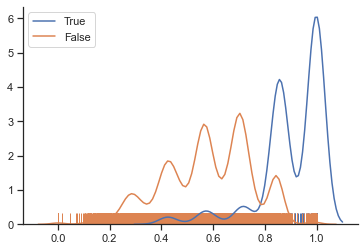

In [65]:
# plot distributions of normalised scores
pairs_true = pairs_test[pairs_test['y'] == True]
pairs_false = pairs_test[pairs_test['y'] == False]

sns.set_style('ticks')
sns.distplot(pairs_true[['X_sum_norm']], hist=False, rug=True, label='True')
sns.distplot(pairs_false[['X_sum_norm']], hist=False, rug=True, label='False')
sns.despine()
sns.set_style('whitegrid')

In [68]:
# take 0.8 as a threshold from the above plot
threshold = 0.8

# balanced accuracy score: https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score
pairs_test['y_pred_1'] = pairs_test['X_sum_norm'].apply(lambda x: x >= threshold)
print(f"average precision: {average_precision_score(pairs_test['y'], pairs_test['X_sum_norm'])}") 
print(f"balanced accuracy @ {threshold}: {balanced_accuracy_score(pairs_test['y'], pairs_test['y_pred_1'])}")

average precision: 0.8315282086850968
balanced accuracy @ 0.8: 0.8938307364704523


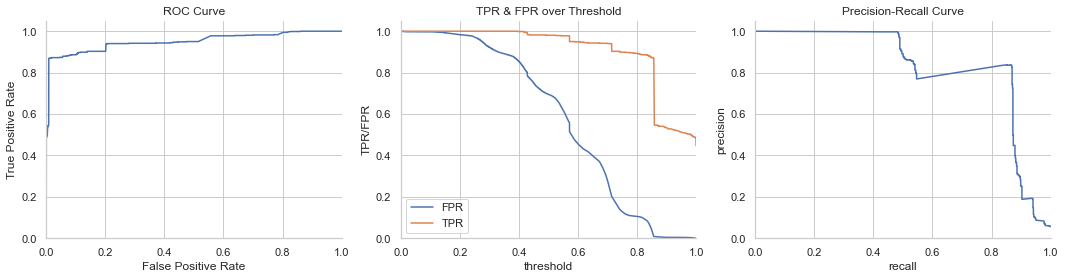

In [122]:
def plot_curves(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_pred_proba)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,4))

    # plot ROC curve
    ax1.plot(fpr, tpr)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    # roc_auc_score(y_true, pairs_test['X_sum_norm'])
    sns.despine()

    # plot TPR, FPR against threshold
    ax2.plot(thresholds, fpr, label='FPR')
    ax2.plot(thresholds, tpr, label='TPR')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('threshold')
    ax2.set_ylabel('TPR/FPR')
    ax2.legend(loc="best")
    ax2.set_title('TPR & FPR over Threshold')
    sns.despine();

    # plot precision-recall curve
    ax3.plot(recall, precision)
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('recall')
    ax3.set_ylabel('precision')
    ax3.set_title('Precision-Recall Curve')
    sns.despine();
    
plot_curves(pairs_test['y'], pairs_test['X_sum_norm'])

### 2.2 Machine Learning Classifier

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### 2.2.1 Logistic regression

In [134]:
logr = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred_proba_logr = logr.predict_proba(X_test)[:,1]

print(f"average precision: {average_precision_score(y_test, y_pred_proba_logr)}") 

average precision: 0.8400111538744915


balanced accuracy @ 0.15: 0.9341708908512084


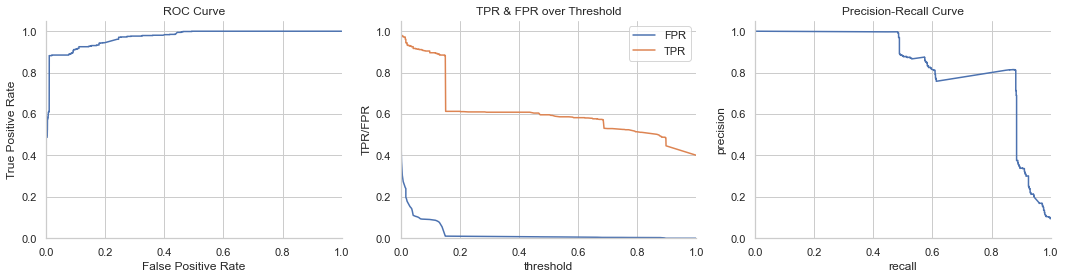

In [146]:
plot_curves(y_test, y_pred_proba_logr)

threshold_logr = 0.15
y_pred_logr = y_pred_proba_logr >= threshold_logr

print(f"balanced accuracy @ {threshold_logr}: {balanced_accuracy_score(y_test, y_pred_logr)}")

#### 2.2 Decision tree

In [202]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=5).fit(X_train, y_train)
y_pred_proba_dtc = dtc.predict_proba(X_test)[:,1]

print(f"average precision: {average_precision_score(y_test, y_pred_proba_dtc)}")

average precision: 0.9549009148264053


balanced accuracy @ 0.5: 0.9705634675833925


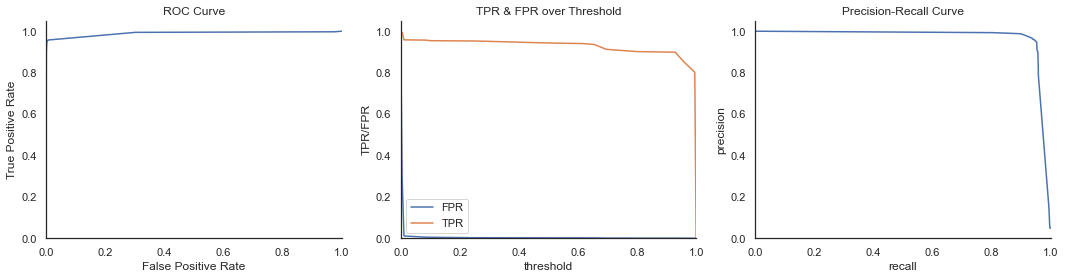

In [203]:
plot_curves(y_test, y_pred_proba_dtc)

threshold_dtc = 0.5
y_pred_dtc = y_pred_proba_dtc >= threshold_dtc

print(f"balanced accuracy @ {threshold_dtc}: {balanced_accuracy_score(y_test, y_pred_dtc)}")

5


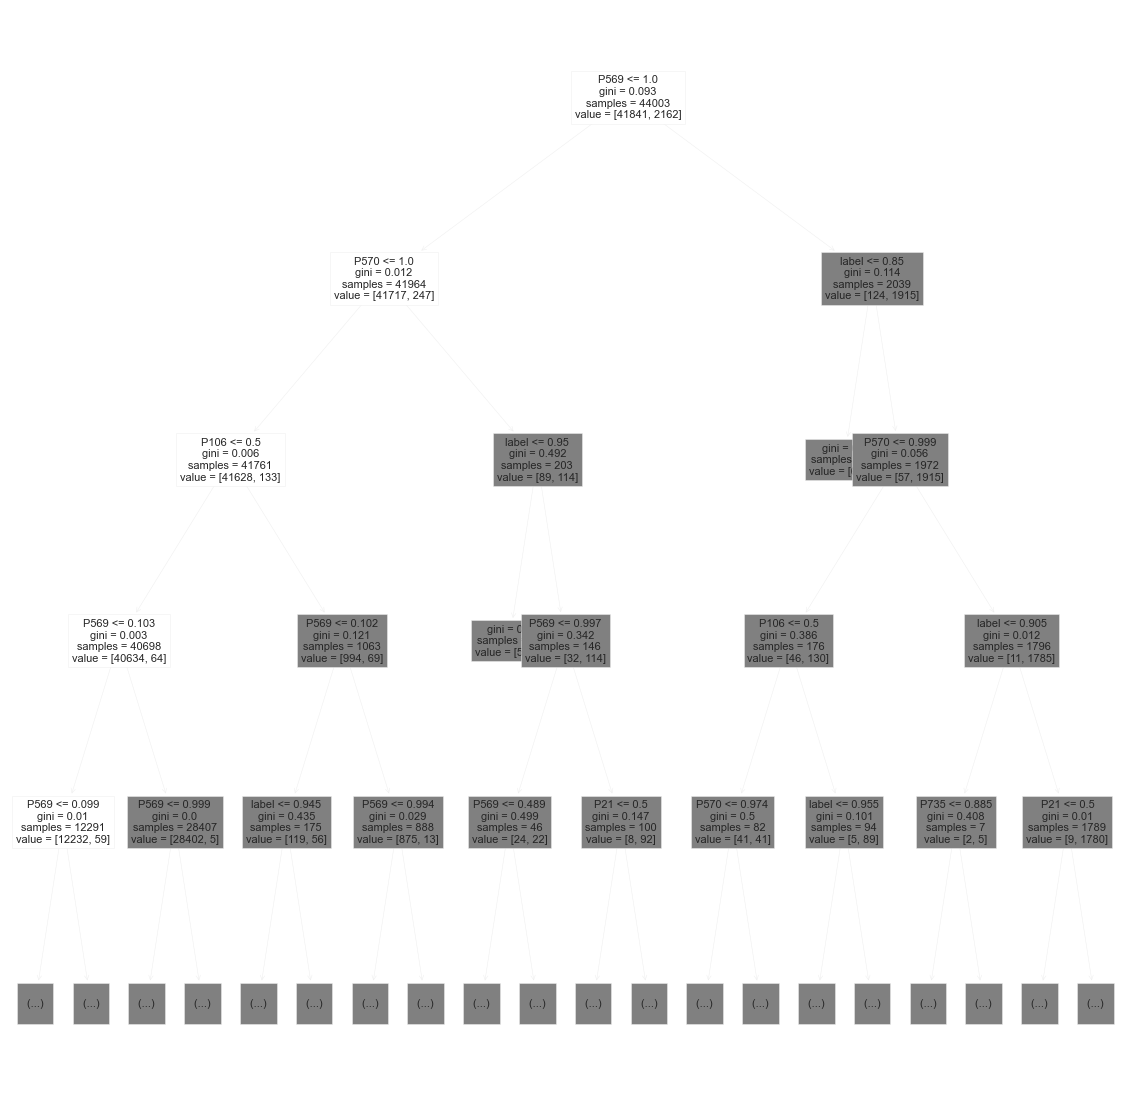

In [204]:
# HOW TO READ: left is True, right is False
# Gini (impurity) is a measure of how bad the split is
from sklearn import tree
print(dtc.get_depth())

with plt.style.context('bmh'):
    _, ax = plt.subplots(figsize=(20,20))
    tree.plot_tree(dtc, fontsize=11, feature_names=pids, max_depth=4);